# Introduction to climlab and 1D grey radiation models

In [74]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import netCDF4 as nc
import climlab

# Validate climlab against analytical solution for 2-layer atmosphere

In [75]:
#  Test in a 2-layer atmosphere
col = climlab.GreyRadiationModel(num_lev=2)
print(col)

climlab Process of type <class 'climlab.model.column.GreyRadiationModel'>. 
State variables and domain shapes: 
  Ts: (1,) 
  Tatm: (2,) 
The subprocess tree: 
Untitled: <class 'climlab.model.column.GreyRadiationModel'>
   LW: <class 'climlab.radiation.greygas.GreyGas'>
   SW: <class 'climlab.radiation.greygas.GreyGasSW'>
   insolation: <class 'climlab.radiation.insolation.FixedInsolation'>



In [76]:
col.subprocess

AttrDict({'LW': <climlab.radiation.greygas.GreyGas object at 0x7f8df92bef70>, 'SW': <climlab.radiation.greygas.GreyGasSW object at 0x7f8df925caf0>, 'insolation': <climlab.radiation.insolation.FixedInsolation object at 0x7f8df925ceb0>})

In [77]:
col.state

AttrDict({'Ts': Field([288.]), 'Tatm': Field([200., 278.])})

In [78]:
col.Ts

Field([288.])

In [79]:
col.Ts[:] = 288.
col.Tatm[:] = np.array([275., 230.])
col.state

AttrDict({'Ts': Field([288.]), 'Tatm': Field([275., 230.])})

In [80]:
LW = col.subprocess['LW']
print (LW)

climlab Process of type <class 'climlab.radiation.greygas.GreyGas'>. 
State variables and domain shapes: 
  Ts: (1,) 
  Tatm: (2,) 
The subprocess tree: 
Untitled: <class 'climlab.radiation.greygas.GreyGas'>



In [81]:
LW.absorptivity

Field([0.47737425, 0.47737425])

In [82]:
LW.absorptivity = 0.58377
LW.absorptivity

Field([0.58377, 0.58377])

In [83]:
col.diagnostics

{'flux_from_sfc': Field([0.]),
 'flux_to_sfc': Field([0.]),
 'flux_to_space': Field([0.]),
 'absorbed': Field([0., 0.]),
 'absorbed_total': Field([0.]),
 'emission': Field([0., 0.]),
 'emission_sfc': Field([0.]),
 'flux_reflected_up': None,
 'insolation': Field([341.3]),
 'coszen': Field([1.]),
 'OLR': None,
 'LW_down_sfc': None,
 'LW_up_sfc': None,
 'LW_absorbed_sfc': None,
 'LW_absorbed_atm': None,
 'LW_emission': None,
 'ASR': None,
 'SW_absorbed_sfc': None,
 'SW_absorbed_atm': None,
 'SW_up_sfc': None,
 'SW_up_TOA': None,
 'SW_down_TOA': None,
 'planetary_albedo': None}

In [84]:
col.compute_diagnostics()
col.diagnostics

{'flux_from_sfc': Field([102.0487]),
 'flux_to_sfc': array([341.3]),
 'flux_to_space': array([102.0487]),
 'absorbed': array([0., 0.]),
 'absorbed_total': 0.0,
 'emission': Field([0., 0.]),
 'emission_sfc': Field([0.]),
 'flux_reflected_up': array([  0.    ,   0.    , 102.0487]),
 'insolation': Field([341.3]),
 'coszen': Field([1.]),
 'OLR': array([295.45584781]),
 'LW_down_sfc': array([171.43120688]),
 'LW_up_sfc': Field([390.10502995]),
 'LW_absorbed_sfc': Field([-218.67382308]),
 'LW_absorbed_atm': array([-229.76426433,  152.9822396 ]),
 'LW_emission': Field([189.31461699,  92.63278385]),
 'ASR': Field([239.2513]),
 'SW_absorbed_sfc': Field([239.2513]),
 'SW_absorbed_atm': array([0., 0.]),
 'SW_up_sfc': Field([102.0487]),
 'SW_up_TOA': array([102.0487]),
 'SW_down_TOA': Field([341.3]),
 'planetary_albedo': Field([0.299])}

In [85]:
col.diagnostics['OLR']

array([295.45584781])

In [86]:
col.state

AttrDict({'Ts': Field([288.]), 'Tatm': Field([275., 230.])})

In [87]:
col.step_forward()

In [88]:
col.state

AttrDict({'Ts': Field([288.42520125]), 'Tatm': Field([271.12458172, 232.58034107])})

In [89]:
# integrate out to radiative equilibrium
col.integrate_years(2.)

Integrating for 730 steps, 730.4844 days, or 2.0 years.
Total elapsed time is 2.0014116660123062 years.


In [90]:
col.diagnostics['ASR'] - col.diagnostics['OLR']

Field([5.95677875e-07])

In [91]:
#  Compare these temperatures against our analytical solutions for radiative equilibrium
col.state

AttrDict({'Ts': Field([296.20384518]), 'Tatm': Field([233.62925764, 262.08988311])})

# Get observed annual, global mean temperature profile

In [92]:
ncep_url = "http://www.esrl.noaa.gov/psd/thredds/dodsC/Datasets/ncep.reanalysis.derived/"
ncep_air = nc.Dataset( ncep_url + "pressure/air.mon.1981-2010.ltm.nc" )
level = ncep_air.variables['level'][:]
lat = ncep_air.variables['lat'][:]
zstar = np.log(level/1000)

In [93]:
Tzon = np.mean(ncep_air.variables['air'][:],axis=(0,3))
Tglobal = np.average( Tzon , weights=np.cos(np.deg2rad(lat)), axis=1) + climlab.constants.tempCtoK

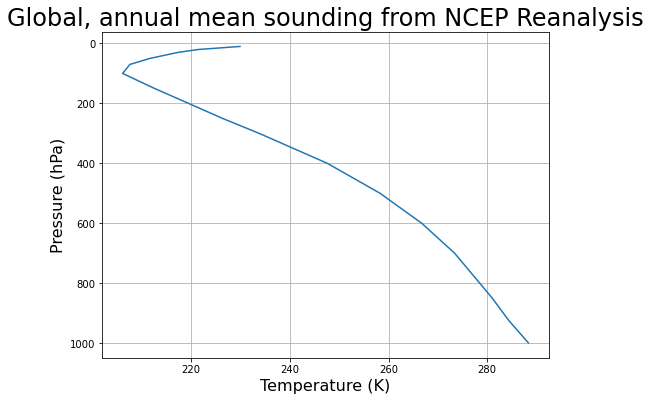

In [94]:
fig = plt.figure( figsize=(8,6) )
ax = fig.add_subplot(111)
ax.plot( Tglobal , level )
ax.invert_yaxis()
ax.set_xlabel('Temperature (K)', fontsize=16)
ax.set_ylabel('Pressure (hPa)', fontsize=16 )
ax.set_title('Global, annual mean sounding from NCEP Reanalysis', fontsize = 24)
ax.grid()

# Create 30-layer model with observed temperatures

In [95]:
#  initialize a grey radiation model with 30 levels
col = climlab.GreyRadiationModel()
print (col)

climlab Process of type <class 'climlab.model.column.GreyRadiationModel'>. 
State variables and domain shapes: 
  Ts: (1,) 
  Tatm: (30,) 
The subprocess tree: 
Untitled: <class 'climlab.model.column.GreyRadiationModel'>
   LW: <class 'climlab.radiation.greygas.GreyGas'>
   SW: <class 'climlab.radiation.greygas.GreyGasSW'>
   insolation: <class 'climlab.radiation.insolation.FixedInsolation'>



In [96]:
# interpolate to 30 evenly spaced pressure levels
lev = col.lev

In [97]:
Tinterp = np.flipud(np.interp(np.flipud(lev), np.flipud(level), np.flipud(Tglobal)))
Tinterp

array([224.34736633, 211.66334534, 206.96233453, 208.29142761,
       212.58644104, 217.19397481, 221.78252157, 226.3520813 ,
       231.30422974, 236.08017476, 240.67991638, 245.279658  ,
       249.35979716, 252.92033386, 256.48087056, 259.66789246,
       262.48139954, 265.29490662, 267.81303914, 270.03579712,
       272.25855509, 274.21642049, 275.90939331, 277.60236613,
       279.29533895, 280.98831177, 282.48550415, 283.98269653,
       285.6810201 , 287.4463874 ])

In [98]:
# Initialize model with observed temperatures
col.Ts[:] = Tglobal[0]
col.Tatm[:] = Tinterp

In [99]:
def plot_sounding(collist):
    color_cycle=['r', 'g', 'b', 'y']
    # col is either a column model object or a list of column model objects
    if isinstance(collist, climlab.Process):
        # make a list with a single item
        collist = [collist]
    fig = plt.figure()
    ax = fig.add_subplot(111)
    for i, col in enumerate(collist):
        ax.plot(col.Tatm, col.lev, color=color_cycle[i])
        ax.plot(col.Ts, climlab.constants.ps, 'o', markersize=12, color=color_cycle[i])
    ax.invert_yaxis()
    ax.set_xlabel('Temperature (K)')
    ax.set_ylabel('Pressure (hPa)')
    ax.grid()
    return ax

<AxesSubplot:xlabel='Temperature (K)', ylabel='Pressure (hPa)'>

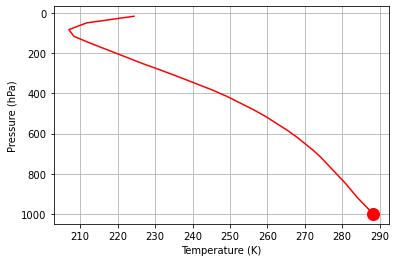

In [100]:
plot_sounding(col)

# Tune absorptivity to get observed OLR

In [101]:
col.compute_diagnostics()
col.diagnostics['OLR']

array([263.15000167])

In [102]:
# Need to tune absorptivity to get OLR = 239
epsarray = np.linspace(0.01, 0.1, 100)
OLRarray = np.zeros_like(epsarray)

In [103]:
for i in range(epsarray.size):
    col.subprocess['LW'].absorptivity = epsarray[i]
    col.compute_diagnostics()
    OLRarray[i] = col.diagnostics['OLR']

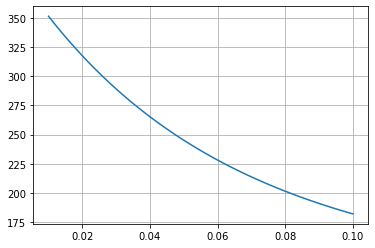

In [104]:
plt.plot(epsarray, OLRarray)
plt.grid()

In [105]:
def OLRanom(eps):
    col.subprocess['LW'].absorptivity = eps
    col.compute_diagnostics()
    return col.diagnostics['OLR'] - 239.

In [106]:
OLRanom(0.02)

array([78.43160417])

In [107]:
# Use numerical root-finding to get the equilibria
from scipy.optimize import brentq
# brentq is a root-finding function
#  Need to give it a function and two end-points
#  It will look for a zero of the function between those end-points
eps = brentq(OLRanom, 0.01, 0.1)
print (eps)

0.05340318130919113


In [108]:
col.subprocess['LW'].absorptivity = eps
col.subprocess['LW'].absorptivity

Field([0.05340318, 0.05340318, 0.05340318, 0.05340318, 0.05340318,
       0.05340318, 0.05340318, 0.05340318, 0.05340318, 0.05340318,
       0.05340318, 0.05340318, 0.05340318, 0.05340318, 0.05340318,
       0.05340318, 0.05340318, 0.05340318, 0.05340318, 0.05340318,
       0.05340318, 0.05340318, 0.05340318, 0.05340318, 0.05340318,
       0.05340318, 0.05340318, 0.05340318, 0.05340318, 0.05340318])

In [109]:
col.compute_diagnostics()
col.diagnostics['OLR']

array([239.])

# Compute radiative forcing for a 2% increase in absorptivity

In [110]:
col2 = climlab.process_like(col)
print (col2)

climlab Process of type <class 'climlab.model.column.GreyRadiationModel'>. 
State variables and domain shapes: 
  Ts: (1,) 
  Tatm: (30,) 
The subprocess tree: 
Untitled: <class 'climlab.model.column.GreyRadiationModel'>
   LW: <class 'climlab.radiation.greygas.GreyGas'>
   SW: <class 'climlab.radiation.greygas.GreyGasSW'>
   insolation: <class 'climlab.radiation.insolation.FixedInsolation'>



In [111]:
col2.subprocess['LW'].absorptivity *= 1.02
col2.subprocess['LW'].absorptivity

Field([0.05447124, 0.05447124, 0.05447124, 0.05447124, 0.05447124,
       0.05447124, 0.05447124, 0.05447124, 0.05447124, 0.05447124,
       0.05447124, 0.05447124, 0.05447124, 0.05447124, 0.05447124,
       0.05447124, 0.05447124, 0.05447124, 0.05447124, 0.05447124,
       0.05447124, 0.05447124, 0.05447124, 0.05447124, 0.05447124,
       0.05447124, 0.05447124, 0.05447124, 0.05447124, 0.05447124])

In [112]:
col2.compute_diagnostics()
col2.diagnostics['OLR']

array([237.15483194])

In [113]:
col2.Ts - col.Ts

Field([0.])

In [114]:
col2.diagnostics['OLR'] - col.diagnostics['OLR']

array([-1.84516806])

In [115]:
RF = -(col2.diagnostics['OLR'] - col.diagnostics['OLR'])
print ('The radiative forcing is %f W/m2.' %RF)

The radiative forcing is 1.845168 W/m2.


# Radiative equilibrium in the 30-layer model

In [116]:
re = climlab.process_like(col)

In [117]:
re.integrate_years(2.)

Integrating for 730 steps, 730.4844 days, or 2.0 years.
Total elapsed time is 1.9986737567564754 years.


In [118]:
#  Check for energy balance
re.diagnostics['ASR'] - re.diagnostics['OLR']

Field([-4.52634367e-07])

<AxesSubplot:xlabel='Temperature (K)', ylabel='Pressure (hPa)'>

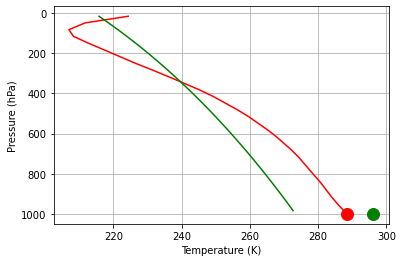

In [119]:
plot_sounding([col, re])

# Radiative-Convective equilibrium in the 30-layer model

In [120]:
rce = climlab.RadiativeConvectiveModel(adj_lapse_rate=6.)
print (rce)

climlab Process of type <class 'climlab.model.column.RadiativeConvectiveModel'>. 
State variables and domain shapes: 
  Ts: (1,) 
  Tatm: (30,) 
The subprocess tree: 
Untitled: <class 'climlab.model.column.RadiativeConvectiveModel'>
   LW: <class 'climlab.radiation.greygas.GreyGas'>
   SW: <class 'climlab.radiation.greygas.GreyGasSW'>
   insolation: <class 'climlab.radiation.insolation.FixedInsolation'>
   convective adjustment: <class 'climlab.convection.convadj.ConvectiveAdjustment'>



In [121]:
rce.subprocess['LW'].absorptivity = eps

In [122]:
rce.integrate_years(2.)

Integrating for 730 steps, 730.4844 days, or 2.0 years.
Total elapsed time is 1.9986737567564754 years.


In [123]:
#  Check for energy balance
rce.diagnostics['ASR'] - rce.diagnostics['OLR']

Field([1.91645699e-06])

<AxesSubplot:xlabel='Temperature (K)', ylabel='Pressure (hPa)'>

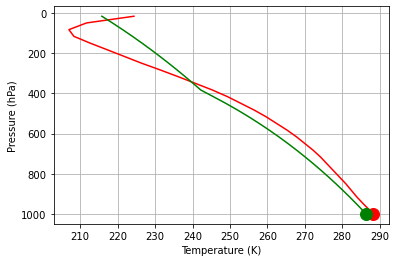

In [124]:
plot_sounding([col, rce])

# Greenhouse warming in RCE model

In [125]:
# ANother 1% increase in absorptivity
rce2 = climlab.process_like(rce)
rce2.subprocess['LW'].absorptivity *= 1.02

In [126]:
rce2.compute_diagnostics()
RF = -(rce2.diagnostics['OLR'] - rce.diagnostics['OLR'])
print ('The radiative forcing is %f W/m2.' %RF)

The radiative forcing is 1.661031 W/m2.


In [127]:
#  Timestep forward, and the check for energy balance
rce2.integrate_years(2.)
rce2.diagnostics['ASR'] - rce2.diagnostics['OLR']

Integrating for 730 steps, 730.4844 days, or 2.0 years.
Total elapsed time is 3.997347513512951 years.


Field([9.8280168e-08])

<AxesSubplot:xlabel='Temperature (K)', ylabel='Pressure (hPa)'>

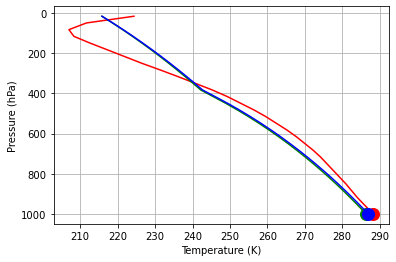

In [128]:
plot_sounding([col, rce, rce2])

In [129]:
ECS = rce2.Ts - rce.Ts
print ('Equilibrium climate sensitivity is %f K.' %ECS)

Equilibrium climate sensitivity is 0.576940 K.


In [130]:
# Calculate the net climate feedback
#  This is the change in TOA flux per degree warming that was necessary to get back to equilibrium.
feedback = -RF/ECS
print ('The net feedback is %f W/m2/K' %feedback )

The net feedback is -2.879038 W/m2/K


In [131]:
#  could calculate a Planck feedback explicitly...
#   What would the TOA flux change be if the warming were perfectly uniform?
rce3 = climlab.process_like(rce)
rce3.subprocess['LW'].absorptivity *= 1.02
rce3.Ts += ECS
rce3.Tatm += ECS